In [1]:
import pandas as pd
import numpy as np

import boto3
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import io
import os

import datetime
from getpass import getpass

import warnings
warnings.filterwarnings('ignore')

In [2]:
AWS_S3_BUCKET = "pipeliner-hb"
AWS_ACCESS_KEY_ID = getpass("AWS_ACCESS_KEY_ID: ")
AWS_SECRET_ACCESS_KEY = getpass("AWS_SECRET_ACCESS_KEY: ")

In [3]:
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

def pd_read_s3_multiple_parquets(filepath, bucket, s3=None, 
                                 s3_client=None, verbose=False, **args):
    if not filepath.endswith('/'):
        filepath = filepath + '/'  # Add '/' to the end
    if s3_client is None:
        s3_client = boto3.client('s3')
    if s3 is None:
        s3 = boto3.resource('s3')
    s3_keys = [item.key for item in s3.Bucket(bucket).objects.filter(Prefix=filepath)
               if item.key.endswith('.parquet')]
    if not s3_keys:
        print('No parquet found in', bucket, filepath)
    elif verbose:
        print('Load parquets:')
        for p in s3_keys: 
            print(p)
    dfs = [pd_read_s3_parquet(key, bucket=bucket, s3_client=s3_client, **args) 
           for key in s3_keys]
    return pd.concat(dfs, ignore_index=True)

In [4]:
df = pd.DataFrame()
for day in range(1, 21):
    path = f'data/parquet/2022-07-{day:02}'
    print(f"Reading {path} ...")
    temp_df = pd_read_s3_multiple_parquets(path, AWS_S3_BUCKET)
    df = df.append(temp_df)

df

Reading data/parquet/2022-07-01 ...
Reading data/parquet/2022-07-02 ...
Reading data/parquet/2022-07-03 ...
Reading data/parquet/2022-07-04 ...
Reading data/parquet/2022-07-05 ...
Reading data/parquet/2022-07-06 ...
Reading data/parquet/2022-07-07 ...
Reading data/parquet/2022-07-08 ...
Reading data/parquet/2022-07-09 ...
Reading data/parquet/2022-07-10 ...
Reading data/parquet/2022-07-11 ...
Reading data/parquet/2022-07-12 ...
Reading data/parquet/2022-07-13 ...
Reading data/parquet/2022-07-14 ...
Reading data/parquet/2022-07-15 ...
Reading data/parquet/2022-07-16 ...
Reading data/parquet/2022-07-17 ...
Reading data/parquet/2022-07-18 ...
Reading data/parquet/2022-07-19 ...
Reading data/parquet/2022-07-20 ...


,datetime,open,high,low,close,volume
0,2022-07-01 00:00:00,19942.21,19978.47,19804.78,19819.00,467.33201
1,2022-07-01 00:01:00,19818.99,19843.73,19766.22,19838.09,337.35428
2,2022-07-01 00:02:00,19838.08,19859.27,19755.34,19759.96,207.34382
3,2022-07-01 00:03:00,19759.96,19800.13,19747.64,19749.21,244.70052
4,2022-07-01 00:04:00,19749.20,19749.95,19671.54,19720.27,244.00150
...,...,...,...,...,...,...
1435,2022-07-20 23:55:00,23260.50,23260.62,23201.19,23221.87,133.72606
1436,2022-07-20 23:56:00,23223.06,23234.93,23183.10,23212.22,169.02871
1437,2022-07-20 23:57:00,23209.65,23217.04,23180.00,23182.15,101.88660
1438,2022-07-20 23:58:00,23184.72,23241.10,23174.67,23223.52,121.00841


# 종가 예측하는 LSTM 모델

## Preprocessing

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
scaler = MinMaxScaler()

scale_cols = ['open', 'high', 'low', 'close', 'volume']
df_scaled = pd.DataFrame(scaler.fit_transform(df[scale_cols]), columns=scale_cols)
df_scaled

,open,high,low,close,volume
0,0.210192,0.202617,0.188612,0.187517,0.141976
1,0.187517,0.177621,0.181508,0.191030,0.102416
2,0.191030,0.180504,0.179504,0.176652,0.062846
3,0.176654,0.169533,0.178085,0.174674,0.074216
4,0.174674,0.160224,0.164065,0.169349,0.074004
...,...,...,...,...,...
28795,0.820838,0.811497,0.814337,0.813729,0.040440
28796,0.813948,0.806731,0.811005,0.811953,0.051185
28797,0.811480,0.803412,0.810433,0.806419,0.030749
28798,0.806892,0.807876,0.809451,0.814032,0.036569


In [7]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled.drop('close', axis=1), df_scaled['close'], test_size=0.2, random_state=0, shuffle=False)

In [8]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(23040, 4) (23040,)
(5760, 4) (5760,)


In [9]:
x_train

,open,high,low,volume
0,0.210192,0.202617,0.188612,0.141976
1,0.187517,0.177621,0.181508,0.102416
2,0.191030,0.180504,0.179504,0.062846
3,0.176654,0.169533,0.178085,0.074216
4,0.174674,0.160224,0.164065,0.074004
...,...,...,...,...
23035,0.441513,0.431495,0.442155,0.016665
23036,0.438524,0.428063,0.441341,0.009992
23037,0.437803,0.426985,0.440313,0.010385
23038,0.438977,0.432732,0.442664,0.019445


In [10]:
y_train

0        0.187517
1        0.191030
2        0.176652
3        0.174674
4        0.169349
           ...   
23035    0.438523
23036    0.437802
23037    0.438976
23038    0.444745
23039    0.440845
Name: close, Length: 23040, dtype: float64

In [14]:
import tensorflow as tf

In [12]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [14]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

2022-07-21 15:07:46.373335: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-21 15:07:46.376359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 15:07:46.380272: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

2022-07-21 15:07:46.526854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 15:07:46.530001: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## Modeling

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

2022-08-03 14:56:04.781653: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-03 14:56:04.782907: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 14:56:04.785272: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [19]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=15, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/15
720/720 [==============================] - 58s 75ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 0.0031 - val_mse: 0.0063

Epoch 00001: val_loss improved from inf to 0.00315, saving model to tmp/ckeckpointer.ckpt
Epoch 2/15
720/720 [==============================] - 48s 66ms/step - loss: 3.1905e-05 - mse: 6.3810e-05 - val_loss: 0.0023 - val_mse: 0.0045

Epoch 00002: val_loss improved from 0.00315 to 0.00225, saving model to tmp/ckeckpointer.ckpt
Epoch 3/15
720/720 [==============================] - 57s 79ms/step - loss: 2.6823e-05 - mse: 5.3646e-05 - val_loss: 0.0019 - val_mse: 0.0038

Epoch 00003: val_loss improved from 0.00225 to 0.00189, saving model to tmp/ckeckpointer.ckpt
Epoch 4/15
720/720 [==============================] - 50s 70ms/step - loss: 2.3918e-05 - mse: 4.7836e-05 - val_loss: 0.0017 - val_mse: 0.0033

Epoch 00004: val_loss improved from 0.00189 to 0.00167, saving model to tmp/ckeckpointer.ckpt
Epoch 5/15
720/720 [==============================] - 50s 70ms/s

## Predict

In [7]:
model.load_weights(filename)

In [21]:
pred = model.predict(test_data)

### Visualization

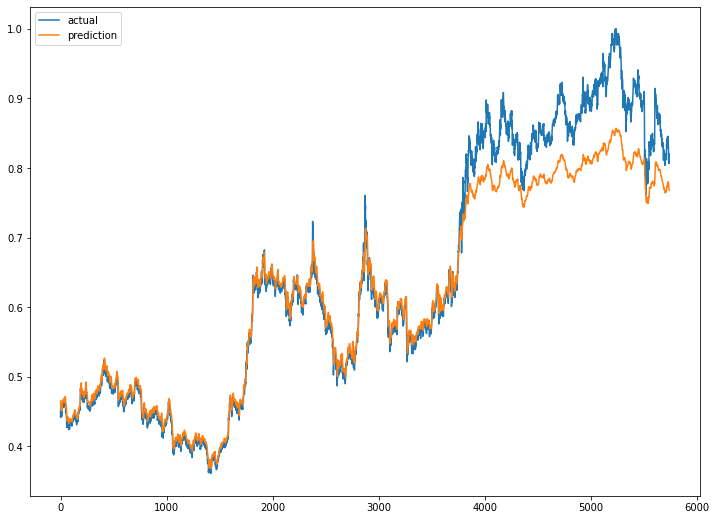

In [22]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [11]:
import pickle
import os

In [15]:
tf.keras.models.save_model(model, '/home/ubuntu/knkwon/modeling/models/lstm_model')

2022-08-03 15:03:37.851375: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/ubuntu/knkwon/modeling/models/lstm_model/assets


INFO:tensorflow:Assets written to: /home/ubuntu/knkwon/modeling/models/lstm_model/assets
